# STAT226 HW3

Seokjun Choi

*All code blocks are python 3 scripts. All scripts are tested under Python 3.10.5 for 64-bit Windows.*

*Runnable .py script:*
- https://github.com/letsjdosth/SpatialStat/blob/main/hw3.py
*and*
- https://github.com/letsjdosth/SpatialStat/blob/main/spatial_util/least_squares.py
- https://github.com/letsjdosth/SpatialStat/blob/main/spatial_util/semi_variogram.py

*The class 'Matern' comes from **HW 1**.*
- https://github.com/letsjdosth/SpatialStat/blob/main/spatial_util/cov_functions.py

*Third-party Dependency: numpy, scipy, matplotlib.*


To begin with, let me implement functions for the least squares(OLS) and the generalized least squares(GLS) fitting.
These functions use QR and Cholesky decompositions and a triangular linear system solver to avoid inverting a matrix directly.
Moreover, as byproducts, the functions return the SSE, the covariance matrix's determinant, and the fitted coefficient.

In [1]:
import csv
from functools import partial
from random import seed, normalvariate

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.optimize as optim
import scipy.linalg

from spatial_util.cov_functions import Matern

def OLS_by_QR(design_X, resp_Y):
    design_X = np.array(design_X)

    beta_dim = design_X.shape[1]
    #design_X = QR, Q:orthogonal(n*n), R:upper-triangular(n*p)
    Q, R = np.linalg.qr(design_X, mode='complete')
    R1 = R[0:beta_dim, 0:beta_dim] #upper-triangular(p*p)
    QtY = np.transpose(Q)@np.array(resp_Y)

    beta_fit = scipy.linalg.solve_triangular(R1, QtY[0:beta_dim], lower=False)
    sum_of_squared_error = sum(QtY[beta_dim:]**2)
    return beta_fit, sum_of_squared_error

def GLS_by_cholesky(design_X, resp_Y, cov_mat_Sigma):
    # cov_mat_Sigma = LLt
    L = np.linalg.cholesky(cov_mat_Sigma)
    log_det_cov_mat_Sigma = np.sum(np.log(np.diag(L)))*2
    
    Z = scipy.linalg.solve_triangular(L, resp_Y, lower=True) #Z = L^(-1)Y
    F = scipy.linalg.solve_triangular(L, design_X, lower=True) #F = L^(-1)X
    #now, Z = F*beta + error(with cov=I)
    
    beta_fit, sum_of_squared_error = OLS_by_QR(F, Z)
    return beta_fit, sum_of_squared_error, log_det_cov_mat_Sigma

## Problem 1 and 2

Let's start with loading the given dataset.
Let me skip describing the dataset (we may find it on soilDB package in R. Maybe...) and directly go to explore the data graphically.

Because some data points have the same location, I put slight jitters to longitude and latitude values.

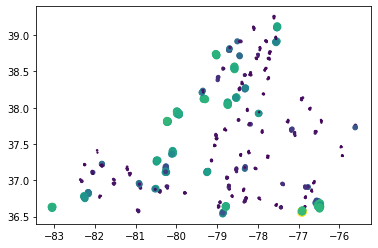

In [2]:
data_soc = []
data_long = []
data_lat = []
with open('data/VA_soil_carbon.csv', newline='') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    next(csv_reader)
    for row in csv_reader:
        data_soc.append(float(row[2]))
        data_long.append(float(row[9]))
        data_lat.append(float(row[10]))


seed(20230213)
data_long_jittered = [long + normalvariate(0,0.01) for long in data_long]
data_lat_jittered = [lat + normalvariate(0,0.01) for lat in data_lat]

plt.scatter(data_long_jittered, data_lat_jittered, s=data_soc, c=data_soc)
plt.show()


The horizontal axis is the longitude, and the vertical axis is the latitude.
The greener color with a bigger circle indicates the larger value at the point.

Points in the upper-left and bottom areas have larger values, making us consider a spatial correlation.
Values do not seem to have a linear trend, so it may be better to fit a high-order polynomial to design a trend model.

Let me try the first-order and the second-order trend model.
After fitting using OLS, I will show the original data, the fitting result, the residuals on the map, the residual plot (with respect to the fitted values), and the normal QQ plot for the residuals.

c:\Users\rtoru\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\collections.py:981: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


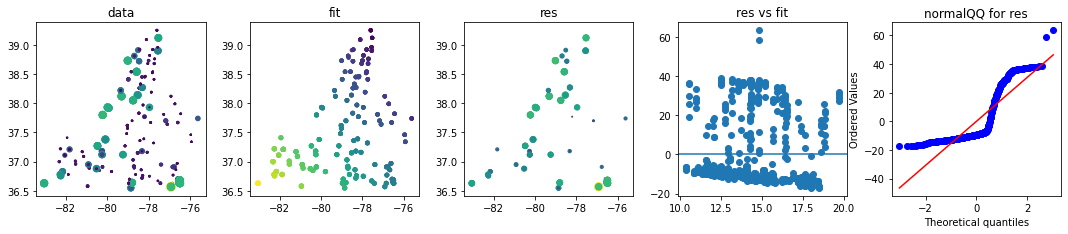

In [3]:
design_1st_X = np.array([[1, x, y] for x,y in zip(data_long, data_lat)])
design_2nd_X = np.array([[1, x, y, x**2, y**2, x*y] for x,y in zip(data_long, data_lat)])
resp_Y = np.array(data_soc)

trend_1st_coeff_OLS_fit, _ = OLS_by_QR(design_1st_X, resp_Y)
trend_2nd_coeff_OLS_fit, _ = OLS_by_QR(design_2nd_X, resp_Y)

trend_1st_fit = design_1st_X@trend_1st_coeff_OLS_fit
trend_2nd_fit = design_2nd_X@trend_2nd_coeff_OLS_fit

trend_1st_residual = resp_Y - trend_1st_fit
trend_2nd_residual = resp_Y - trend_2nd_fit

fig1, axs1 = plt.subplots(1, 5, figsize=(15, 3))
fig1.tight_layout()
axs1[0].scatter(data_long, data_lat, s=data_soc, c=data_soc)
axs1[0].set_title("data")
axs1[1].scatter(data_long, data_lat, s=trend_1st_fit, c=trend_1st_fit)
axs1[1].set_title("fit")
axs1[2].scatter(data_long, data_lat, s=trend_1st_residual, c=trend_1st_residual)
axs1[2].set_title("res")
axs1[3].scatter(trend_1st_fit, trend_1st_residual)
axs1[3].axhline(0)
axs1[3].set_title("res vs fit")
stats.probplot(trend_1st_residual, dist=stats.norm, plot=axs1[4])
axs1[4].set_title("normalQQ for res")
plt.show()


The above result comes from the first-order polynomial trend fit.

The fitted result is very different from the original data. Residuals are high in the top part, showing a structure.
The normal Q-Q plot indicates that the residual is not following the Gaussian distribution.

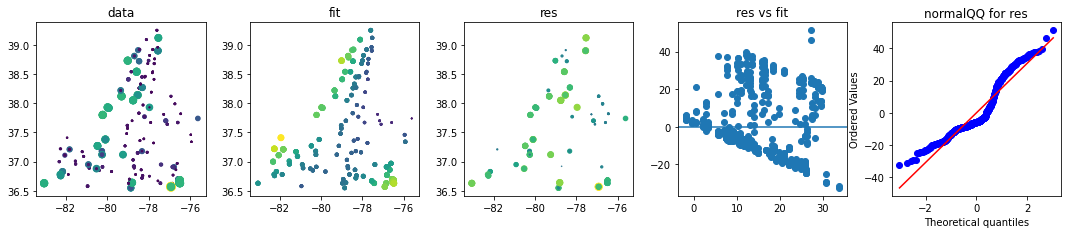

In [4]:
fig2, axs2 = plt.subplots(1, 5, figsize=(15, 3))
fig2.tight_layout()
axs2[0].scatter(data_long, data_lat, s=data_soc, c=data_soc)
axs2[0].set_title("data")
axs2[1].scatter(data_long, data_lat, s=trend_2nd_fit, c=trend_2nd_fit)
axs2[1].set_title("fit")
axs2[2].scatter(data_long, data_lat, s=trend_2nd_residual, c=trend_2nd_residual)
axs2[2].set_title("res")
axs2[3].scatter(trend_2nd_fit, trend_2nd_residual)
axs2[3].axhline(0)
axs2[3].set_title("res vs fit")
stats.probplot(trend_2nd_residual, dist=stats.norm, plot=axs2[4])
axs2[4].set_title("normalQQ for res")
plt.show()

This result is produced from the second-order polynomial trend fit.

The fitted value is not perfect for explaining the original data, but it seems relatively better than the first-order polynomial fit.
Residual values on the map show some spatial clusters, and the residual plot with fitted values also displays some structure.
It would be better to consider an additional component to explain the spatial correlation to our model.
The normal QQ plot is not very straight, but many points are close to the red line.
It seems fine to use a gaussian process for the residual modeling.

Next, let me plot the semivariogram of the residuals to explore the underlying covariance structure.
Three functions in the below block will give us the semivariogram cloud, the directional semivariogram clouds, and their smoothed results through binning.
For (my) convenience in the implementation, I consider only the four directions for the directional semivariogram: up, down, right, and left.
Note that I use just the 2-dimensional Euclidean norm treating longitude and latitude as the same distance 'unit' on a plain.
(It may be problematic, though.)

In [5]:
def semi_variogram(data, long, lat):
    dist_u = []
    vario_r = []
    for i, (dat_i, long_i, lat_i) in enumerate(zip(data, long, lat)):
        for j, (dat_j, long_j, lat_j) in enumerate(zip(data, long, lat)):
            if i>j:
                pass
            else:
                dist_ij = ((long_i-long_j)**2 + (lat_i-lat_j)**2)**0.5
                vario_ij = 0.5 * (dat_i-dat_j)**2
                dist_u.append(dist_ij)
                vario_r.append(vario_ij)
    return dist_u, vario_r

def directional_semi_variogram(data, long, lat, direction):
    dist_u = []
    vario_r = []
    for i, (dat_i, long_i, lat_i) in enumerate(zip(data, long, lat)):
        for j, (dat_j, long_j, lat_j) in enumerate(zip(data, long, lat)):
            if i>j:
                pass
            else:
                if direction == 0 and long_i<long_j: #right
                    dist_ij = ((long_i-long_j)**2 + (lat_i-lat_j)**2)**0.5
                    vario_ij = 0.5 * (dat_i-dat_j)**2
                    dist_u.append(dist_ij)
                    vario_r.append(vario_ij)
                elif direction == 1 and long_i>long_j: #left
                    dist_ij = ((long_i-long_j)**2 + (lat_i-lat_j)**2)**0.5
                    vario_ij = 0.5 * (dat_i-dat_j)**2
                    dist_u.append(dist_ij)
                    vario_r.append(vario_ij)
                elif direction == 2 and lat_i<lat_j: #up
                    dist_ij = ((long_i-long_j)**2 + (lat_i-lat_j)**2)**0.5
                    vario_ij = 0.5 * (dat_i-dat_j)**2
                    dist_u.append(dist_ij)
                    vario_r.append(vario_ij)
                elif direction == 3 and lat_i>lat_j: #down
                    dist_ij = ((long_i-long_j)**2 + (lat_i-lat_j)**2)**0.5
                    vario_ij = 0.5 * (dat_i-dat_j)**2
                    dist_u.append(dist_ij)
                    vario_r.append(vario_ij)
                    
    return dist_u, vario_r

def binning(dist, vario, num_bins):
    max_u = max(dist)
    bin_tres_u = [(i+1)*max_u/num_bins for i in range(num_bins)]
    bin_middle_u = [(i+0.5)*max_u/num_bins for i in range(num_bins)]
    bin_vario_list = [[] for _ in range(num_bins)]
    # print(bin_tres_u)

    for u, r in zip(dist,vario):
        add_flag = False
        for i, tres in enumerate(bin_tres_u):
            if u<tres:
                bin_vario_list[i].append(r)
                add_flag = True
                break
        if not add_flag:
            bin_vario_list[-1].append(r)
            
    bin_vario_r = [np.mean(x) for x in bin_vario_list]
    # print(bin_vario_r)
    return bin_middle_u, bin_vario_r

possible nugget: 213.9847365046613


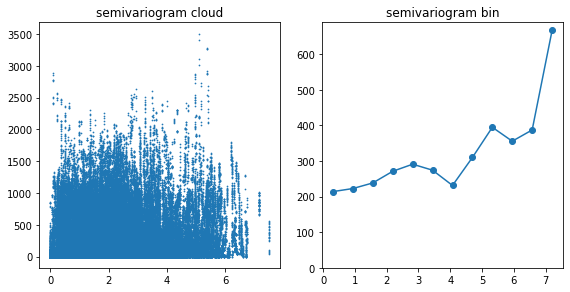

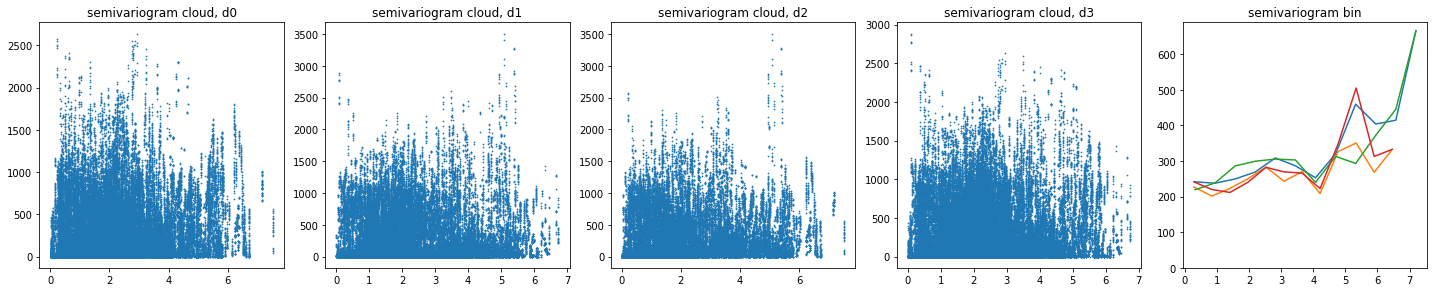

In [6]:
dist_u, vario_r = semi_variogram(trend_2nd_residual, data_long, data_lat)
dist_u_d0, vario_r_d0 = directional_semi_variogram(trend_2nd_residual, data_long, data_lat, 0) #right
dist_u_d1, vario_r_d1 = directional_semi_variogram(trend_2nd_residual, data_long, data_lat, 1) #left
dist_u_d2, vario_r_d2 = directional_semi_variogram(trend_2nd_residual, data_long, data_lat, 2) #up
dist_u_d3, vario_r_d3 = directional_semi_variogram(trend_2nd_residual, data_long, data_lat, 3) #down

bin_dist_u, bin_vario_r = binning(dist_u, vario_r, 12)
bin_dist_u_d0, bin_vario_r_d0 = binning(dist_u_d0, vario_r_d0, 12)
bin_dist_u_d1, bin_vario_r_d1 = binning(dist_u_d1, vario_r_d1, 12)
bin_dist_u_d2, bin_vario_r_d2 = binning(dist_u_d2, vario_r_d2, 12)
bin_dist_u_d3, bin_vario_r_d3 = binning(dist_u_d3, vario_r_d3, 12)
print("possible nugget:", bin_vario_r[0])

fig_vario, axs_vario = plt.subplots(1, 2, figsize=(8, 4))
fig_vario.tight_layout()
axs_vario[0].scatter(dist_u, vario_r, s=0.5)
axs_vario[0].set_title("semivariogram cloud")
axs_vario[1].plot(bin_dist_u, bin_vario_r)
axs_vario[1].scatter(bin_dist_u, bin_vario_r)
axs_vario[1].set_title("semivariogram bin")
axs_vario[1].set_ylim(0, axs_vario[1].get_ylim()[1])
plt.show()

fig_vario_d, axs_vario_d = plt.subplots(1, 5, figsize=(20, 4))
fig_vario_d.tight_layout()
axs_vario_d[0].scatter(dist_u_d0, vario_r_d0, s=0.5)
axs_vario_d[0].set_title("semivariogram cloud, d0")
axs_vario_d[1].scatter(dist_u_d1, vario_r_d1, s=0.5)
axs_vario_d[1].set_title("semivariogram cloud, d1")
axs_vario_d[2].scatter(dist_u_d2, vario_r_d2, s=0.5)
axs_vario_d[2].set_title("semivariogram cloud, d2")
axs_vario_d[3].scatter(dist_u_d3, vario_r_d3, s=0.5)
axs_vario_d[3].set_title("semivariogram cloud, d3")
axs_vario_d[4].plot(bin_dist_u_d0, bin_vario_r_d0)
axs_vario_d[4].plot(bin_dist_u_d1, bin_vario_r_d1)
axs_vario_d[4].plot(bin_dist_u_d2, bin_vario_r_d2)
axs_vario_d[4].plot(bin_dist_u_d3, bin_vario_r_d3)
axs_vario_d[4].set_title("semivariogram bin")
axs_vario_d[4].set_ylim(0, axs_vario_d[4].get_ylim()[1])
plt.show()


For binning, I used 12 equally-spaced bins.

The smoothed semivariogram indicates the existence of a nugget cause it does not start at 0.
Note that the values on the right part are very unreliable because there are only a few points.

In the directional semivariogram clouds and the smoothed plot, each direction is:

- d0(blue): right
- d1(orange): left
- d2(green): up
- d4(red): down

All smoothed curves on the smoothed directional semivariogram are similar if we ignore the unreliable part (the far right).
In other words, a directional effect on the covariance looks weak.
Thus, we can use an isotropic covariance model.

## Problem 3

Based on the observed semivariogram above, let me fit the Matern covariance model.
Here, I will fix the smoothness parameter of the Matern as $v=0.5, 1, 1.5, 2.5$ and find the scale $\sigma^2$ and range $\phi$ using the least squares.

I will NOT consider a nugget term, even if the semivariogram shows a nonzero intercept at 0, and even if we can get the fitted nugget value through the LS fit.
This is because the smoothed semivariogram looks too flat from zero distance to distance 4.
If I put a nugget like 210, then almost all variation is treated as unexplainable, which is not a beautiful situation.
Who likes a model treating 2/3 of the variation as noise?

In addition, I will exclude the rightest bin to fit. The smoothed value is not reliable.
It may be better to ignore more bins, but I do not know what is the optimal number of bins to exclude.
Sadly, however, fitted covariance parameters highly depend on the number of total bins in the smoothing process and the number of bins ignored in the fitting procedure.

c:\gitProject\SpatialStat\spatial_util\cov_functions.py:165: RuntimeWarning: invalid value encountered in double_scalars
  semi_var = self.sigma2 *(1 - (1/(2**(self.nu-1)*gamma(self.nu))) * ((dist/self.phi)**self.nu) * kv(self.nu, dist/self.phi))


v05:  final_simplex: (array([[304.42564178,   0.39953648],
       [304.42564187,   0.39953597],
       [304.425569  ,   0.39953607]]), array([33825.44697123, 33825.44697124, 33825.44697124]))
           fun: 33825.44697122795
       message: 'Optimization terminated successfully.'
          nfev: 264
           nit: 139
        status: 0
       success: True
             x: array([304.42564178,   0.39953648])
v10:  final_simplex: (array([[2.98652597e+02, 1.69885220e-01],
       [2.98652533e+02, 1.69885285e-01],
       [2.98652586e+02, 1.69885085e-01]]), array([35296.9331117 , 35296.93311171, 35296.93311171]))
           fun: 35296.93311170239
       message: 'Optimization terminated successfully.'
          nfev: 186
           nit: 98
        status: 0
       success: True
             x: array([2.98652597e+02, 1.69885220e-01])
v15:  final_simplex: (array([[2.98041257e+02, 1.28117143e-01],
       [2.98041320e+02, 1.28117397e-01],
       [2.98041271e+02, 1.28117050e-01]]), array([35529

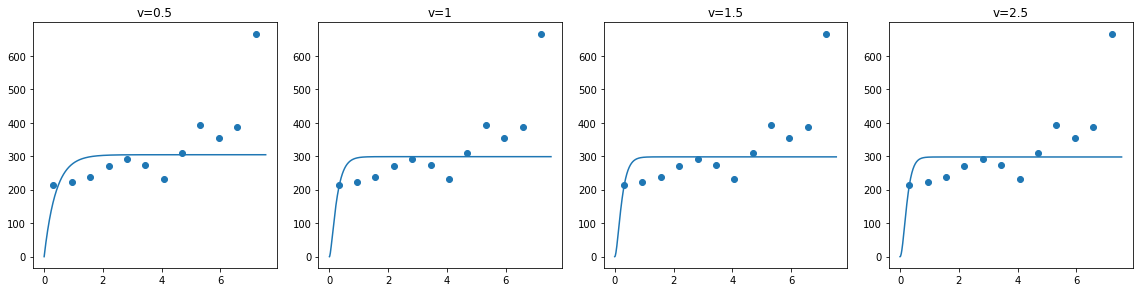

In [7]:
def minimize_func_base(x, nu_smoothness, bin_dist_u, bin_semivario_r):
    bin_dist_u = bin_dist_u[0:-1]
    bin_semivario_r = bin_semivario_r[0:-1]

    scale_sigma2 = x[0]
    range_phi = x[1]
    matern_inst = Matern(nu_smoothness, scale_sigma2, range_phi)
    squared_sum = 0
    for u,r in zip(bin_dist_u, bin_semivario_r):
        squared_sum += ((matern_inst.semi_variogram(u) - r)**2)
    return squared_sum

minimize_func_v05 = partial(minimize_func_base, nu_smoothness=0.5, bin_dist_u=bin_dist_u, bin_semivario_r=bin_vario_r)
optim_result_v05 = optim.minimize(minimize_func_v05, [1,1], method='nelder-mead')
print("v05:",optim_result_v05)
matern_inst_v05 = Matern(0.5, optim_result_v05.x[0], optim_result_v05.x[1])

minimize_func_v10 = partial(minimize_func_base, nu_smoothness=1, bin_dist_u=bin_dist_u, bin_semivario_r=bin_vario_r)
optim_result_v10 = optim.minimize(minimize_func_v10, [1,1], method='nelder-mead')
print("v10:",optim_result_v10)
matern_inst_v10 = Matern(1, optim_result_v10.x[0], optim_result_v10.x[1])


minimize_func_v15 = partial(minimize_func_base, nu_smoothness=1.5, bin_dist_u=bin_dist_u, bin_semivario_r=bin_vario_r)
optim_result_v15 = optim.minimize(minimize_func_v15, [1,1], method='nelder-mead')
print("v15:",optim_result_v15)
matern_inst_v15 = Matern(1.5, optim_result_v15.x[0], optim_result_v15.x[1])

minimize_func_v25 = partial(minimize_func_base, nu_smoothness=2.5, bin_dist_u=bin_dist_u, bin_semivario_r=bin_vario_r)
optim_result_v25 = optim.minimize(minimize_func_v25, [1,1], method='nelder-mead')
print("v25:",optim_result_v25)
matern_inst_v25 = Matern(2.5, optim_result_v25.x[0], optim_result_v25.x[1])

fig_vario_vs, axs_vario_vs = plt.subplots(1, 4, figsize=(4*4, 4))
fig_vario_vs.tight_layout()
axs_vario_vs[0].scatter(bin_dist_u, bin_vario_r)
axs_vario_vs[0].set_title("v=0.5")
matern_inst_v05.plot_semi_variogram(0, axs_vario_vs[0].get_xlim()[1], 0.01, plt_axis=axs_vario_vs[0], show=False)
axs_vario_vs[1].scatter(bin_dist_u, bin_vario_r)
axs_vario_vs[1].set_title("v=1")
matern_inst_v10.plot_semi_variogram(0, axs_vario_vs[1].get_xlim()[1], 0.01, plt_axis=axs_vario_vs[1], show=False)
axs_vario_vs[2].scatter(bin_dist_u, bin_vario_r)
axs_vario_vs[2].set_title("v=1.5")
matern_inst_v15.plot_semi_variogram(0, axs_vario_vs[2].get_xlim()[1], 0.01, plt_axis=axs_vario_vs[2], show=False)
axs_vario_vs[3].scatter(bin_dist_u, bin_vario_r)
axs_vario_vs[3].set_title("v=2.5")
matern_inst_v25.plot_semi_variogram(0, axs_vario_vs[3].get_xlim()[1], 0.01, plt_axis=axs_vario_vs[3], show=False)
plt.show()

The console output shows the fitting results at each $v=0.5, 1, 1.5, 2.5$, in order.
For each case, the 'x' is the fitted $\sigma^2$ and $\phi$.

All optimization results seem fine.

With increasing $v$, $\phi$ decreases. $sigma^2$ is relatively stable.

## Problem 4

Here, I will minimize the negative profile likelihood.

When $X$ is the design matrix of the second polynomial trend model, $Y$ is the response(*soc*), and $\Sigma$ is the covariance matrix constructed with Matern covariance function,
The profile likelihood is
$$l(\sigma^2, \phi) = -0.5 log(|\Sigma(\sigma^2,\phi)|) - 0.5((Y-X\hat{\beta}(\sigma^2,\phi))^T \Sigma(\sigma^2,\phi)^{-1}(Y-X\hat{\beta}(\sigma^2,\phi)))$$
where
$$\hat{\beta}(\sigma^2,\phi)=(X^T\Sigma(\sigma^2,\phi)^{-1}X)^{-1}X^T \Sigma(\sigma^2,\phi)^{-1}Y$$
So it is purely a function of $\sigma^2$, and $\phi$.

The $\hat{\beta}$ is the GLS estimator if we fix $\sigma^2, \phi$. 
So, we can use the GLS and OLS fitting functions I defined at the beginning.
With the byproducts of the decompositions, we can get SSE and determinant, so all terms can be calculated by plugging them in.
We do not need to calculate the inverse and determinant terms directly.

I do not include a nugget term to show that the likelihood's shape is terrible. 
(Yes. The marginal likelihood approach is so valuable!)

I think we can also profile $\sigma^2$. To make a contour plot over $\sigma^2$ and $\phi$, however, I will not do it now.

In [8]:
seed(20230213)
data_long_jittered = [long + normalvariate(0,0.01) for long in data_long]
data_lat_jittered = [lat + normalvariate(0,0.01) for lat in data_lat]


def negative_profile_likelihood(scale_sigma2_range_phi, smoothness_nu, trend_design_X, resp_Y, data_long, data_lat, nugget=0):
    #profile: beta
    scale_sigma2 = scale_sigma2_range_phi[0]
    range_phi = scale_sigma2_range_phi[1]
    matern_scale1_inst = Matern(smoothness_nu, 1, range_phi)
    data_points = [[lon, lat] for lon, lat in zip(data_long, data_lat)]
    matern_cov = matern_scale1_inst.cov_matrix(data_points)
    matern_cov = scale_sigma2*matern_cov + nugget*np.eye(matern_cov.shape[0])

    _, sse_gls, log_det_matern_cov_mat = GLS_by_cholesky(trend_design_X, resp_Y, matern_cov)

    p_lik = -0.5*log_det_matern_cov_mat - 0.5*sse_gls
    return -p_lik


pmle_optim_object = partial(negative_profile_likelihood, trend_design_X=design_2nd_X, resp_Y=resp_Y, data_long=data_long_jittered, data_lat=data_lat_jittered, nugget=0)
# optim_result_pmle = optim.minimize(pmle_optim_object, [240, 0.056], args=(0.5), method='Nelder-Mead', options={"maxiter":10})
# print(optim_result_pmle)

All optimization algorithms perform very poorly, and that is the reason that I comment the last two lines out.
It is almost impossible to satisfy the reasonably narrow stopping rule.
On the other hand, it stops at very different points if we relax the stopping rule.

This is because the likelihood is too flat in the too wide area near the optimum.
To see it, we can make a contour plot near the optimum.
The next script block produce contour plots for $v=0.5, 1, 1.5, 2.5$, respectively.

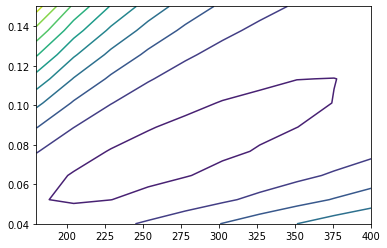

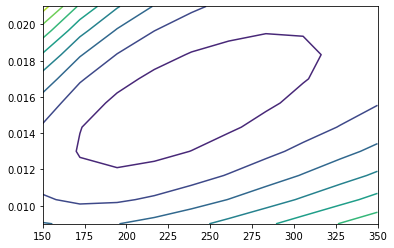

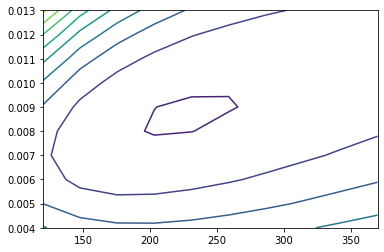

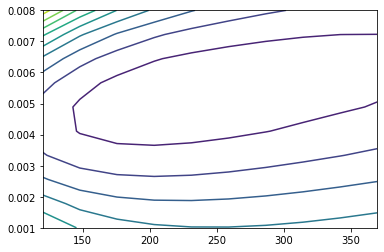

In [9]:
def gen_contour_level_matrix_for_likelihood(meshgrid_sigma2, meshgrid_phi, nu_smoothness):
    val_on_grid = np.empty(meshgrid_sigma2.shape)
    for i in range(meshgrid_sigma2.shape[0]):
        for j in range(meshgrid_sigma2.shape[1]):
            sigma2 = meshgrid_sigma2[i,j]
            phi = meshgrid_phi[i,j]
            val = pmle_optim_object([sigma2, phi], nu_smoothness)
            # print(i, j, sigma2, phi, val)
            val_on_grid[i,j] = val
    return val_on_grid


grid_sigma2 = np.linspace(180, 400, 10)
grid_phi = np.linspace(0.04, 0.15, 10)
meshgrid_sigma2, meshgrid_phi = np.meshgrid(grid_sigma2, grid_phi)
contour_level_mat = gen_contour_level_matrix_for_likelihood(meshgrid_sigma2, meshgrid_phi, nu_smoothness=0.5)
plt.contour(grid_sigma2, grid_phi, contour_level_mat, levels=10)
plt.show()

grid_sigma2 = np.linspace(150, 350, 10)
grid_phi = np.linspace(0.009, 0.021, 10)
meshgrid_sigma2, meshgrid_phi = np.meshgrid(grid_sigma2, grid_phi)
contour_level_mat = gen_contour_level_matrix_for_likelihood(meshgrid_sigma2, meshgrid_phi, nu_smoothness=1)
plt.contour(grid_sigma2, grid_phi, contour_level_mat, levels=10)
plt.show()

grid_sigma2 = np.linspace(120, 370, 10)
grid_phi = np.linspace(0.004, 0.013, 10)
meshgrid_sigma2, meshgrid_phi = np.meshgrid(grid_sigma2, grid_phi)
contour_level_mat = gen_contour_level_matrix_for_likelihood(meshgrid_sigma2, meshgrid_phi, nu_smoothness=1.5)
plt.contour(grid_sigma2, grid_phi, contour_level_mat, levels=10)
plt.show()

grid_sigma2 = np.linspace(120, 370, 10)
grid_phi = np.linspace(0.001, 0.008, 10)
meshgrid_sigma2, meshgrid_phi = np.meshgrid(grid_sigma2, grid_phi)
contour_level_mat = gen_contour_level_matrix_for_likelihood(meshgrid_sigma2, meshgrid_phi, nu_smoothness=2.5)
plt.contour(grid_sigma2, grid_phi, contour_level_mat, levels=10)
plt.show()

The vertical axis is $\phi$, and the horizontal axis is $\sigma^2$. 
(Please be careful. Every plot has a different range of each axis.)
From top to bottom, the smoothness parameter $v$ is 0.5, 1, 1.5, and 2.5.

Every plot looks super bad to optimize.
For example, at $v=1$, if we fix $\phi=0.08$, the likelihood is flat in the vast range of $\sigma^2 \in (225,325)$.
For some inference purposes, any values in this range will be acceptable.
Nevertheless, picking exactly one point may be a too hard problem numerically.
So let me skip reporting the approximated MLE on the grid.
You might find that I only used $10\times 10$ grid points to construct each contour plot. so it is nonsense to pick one among ten $\sigma^2$ on $(150,400)$.

## Problem 5

Let me use the marginal likelihood in slide 6.
Again, all terms in the marginal likelihood expression can be easily calculated with byproducts of the QR and Cholesky decomposition of the GLS fitting procedure.
Since we need the $F$ matrix (following the slide's notation) to calculate the middle term of the marginal likelihood, I will repeat the code of the function fitting GLS.

In [10]:
def marginal_likelihood(range_phi, smoothness_nu, trend_design_X, resp_Y, data_long, data_lat, nugget=0):
    range_phi = range_phi[0]
    n_data = len(resp_Y)
    matern_scale1_inst = Matern(smoothness_nu, 1, range_phi)
    data_points = [[lon, lat] for lon, lat in zip(data_long, data_lat)]
    matern_cov = matern_scale1_inst.cov_matrix(data_points)
    matern_cov = matern_cov + nugget*np.eye(matern_cov.shape[0])

    # cov_mat_Sigma = LLt
    L = np.linalg.cholesky(matern_cov)
    log_det_matern_cov = np.sum(np.log(np.diag(L)))*2
    
    Z = scipy.linalg.solve_triangular(L, resp_Y, lower=True) #Z = L^(-1)Y
    F = scipy.linalg.solve_triangular(L, trend_design_X, lower=True) #F = L^(-1)X
    #now, Z = F*beta + error(with cov=I)
    
    beta_fit, S2 = OLS_by_QR(F, Z)
    DtVinvD = np.transpose(F)@F

    m_lik = -0.5*log_det_matern_cov -0.5*np.linalg.slogdet(DtVinvD)[1] -0.5*(n_data-len(beta_fit))*np.log(S2)

    return m_lik

mmle_optim_object = partial(marginal_likelihood, trend_design_X=design_2nd_X, resp_Y=resp_Y, data_long=data_long_jittered, data_lat=data_lat_jittered, nugget=0)


v=0.5, maximum at: 0.08


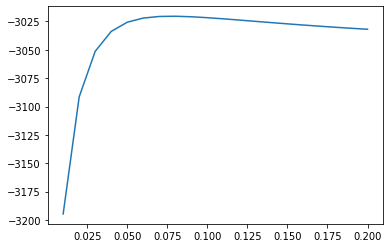

v=1, maximum at: 0.016


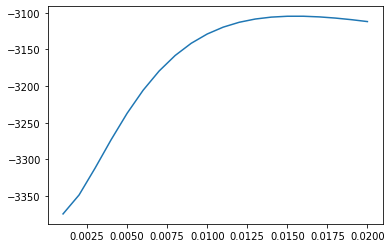

v=1.5, maximum at: 0.008578947368421054


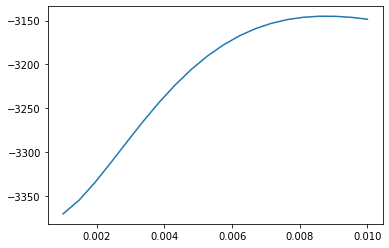

v=2.5, maximum at: 0.005263157894736842


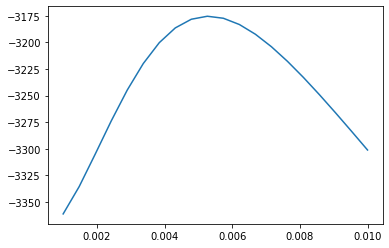

In [12]:
grid_phi = np.linspace(0.01, 0.2, 20)
level_list_marginal = [mmle_optim_object([p], 0.5) for p in grid_phi]
print("v=0.5, maximum at:", grid_phi[np.argmax(level_list_marginal)])
plt.plot(grid_phi, level_list_marginal)
plt.show()

grid_phi = np.linspace(0.001, 0.02, 20)
level_list_marginal = [mmle_optim_object([p], 1) for p in grid_phi]
print("v=1, maximum at:", grid_phi[np.argmax(level_list_marginal)])
plt.plot(grid_phi, level_list_marginal)
plt.show()

grid_phi = np.linspace(0.001, 0.01, 20)
level_list_marginal = [mmle_optim_object([p], 1.5) for p in grid_phi]
print("v=1.5, maximum at:", grid_phi[np.argmax(level_list_marginal)])
plt.plot(grid_phi, level_list_marginal)
plt.show()

grid_phi = np.linspace(0.001, 0.01, 20)
level_list_marginal = [mmle_optim_object([p], 2.5) for p in grid_phi]
print("v=2.5, maximum at:", grid_phi[np.argmax(level_list_marginal)])
plt.plot(grid_phi, level_list_marginal)
plt.show()

From top to bottom, log marginal likelihoods are shown for $v=0.5, 1, 1.5$, and $2.5$, respectively.
The horizontal axis is for $\phi$. (Please be careful to the range of the horizontal axis of each plot.)

They look much better to optimize, which are less flat near their peaks.